# BOOSTING AND ADABOOST CLASSIFIER

Before we start building the model with the realative search for the best hyperparameters we need to do the dataset preparation. For this purpose we create an extended dataset that encloses all the remaining information of the races and includes in the rows the information of the cyclists.

## DATASET PREPARATION

In [1]:
import pandas as pd
from os import path
import numpy as np
%run ../task4_machine_learning/preprocessing.py

X_train, y_train, X_test, y_test, columns_to_keep = get_train_test_data()

In [2]:
from sklearn.utils import resample
import pandas as pd

# Combine X_train and y_train in a unique dataset
train_set = pd.concat([X_train, y_train], axis=1)
train_set.columns = list(X_train.columns) + ['label']  # Dai un nome alla colonna 'label'

# Divide between majority and minority classes
majority_class = train_set[train_set['label'] == 0]
minority_class = train_set[train_set['label'] == 1]

# Number of sampling to mantain
samples_per_class = len(majority_class)

# oversampling of the minority class
minority_upsampled = resample(
    minority_class,
    replace=True,                # Sampling with replacement
    n_samples=samples_per_class, # Number of sampling equals to majority class
    random_state=42
)

# combine the two classes in a balanced dataset
balanced_train_set = pd.concat([majority_class, minority_upsampled])

# divide between features and label
X_train = balanced_train_set.drop(columns=['label'])
y_train = balanced_train_set['label']

print("Distribution of the balaced classses:")
print(y_train.value_counts())

Distribution of the balaced classses:
label
0    460644
1    460644
Name: count, dtype: int64


## Boosting

 Boosting in general is the practice of taking multiple weak base classifiers (“weak learners”) and pulling them independently on the same portions of the dataset. Initially the classifier is chosen then the training process starts, each trained weak learner is evaluated based on the final error after training. Eventually we will end up with “n_estimators” estimators who will take a vote (weighted by error) to decide the label of the still unclassified rows.

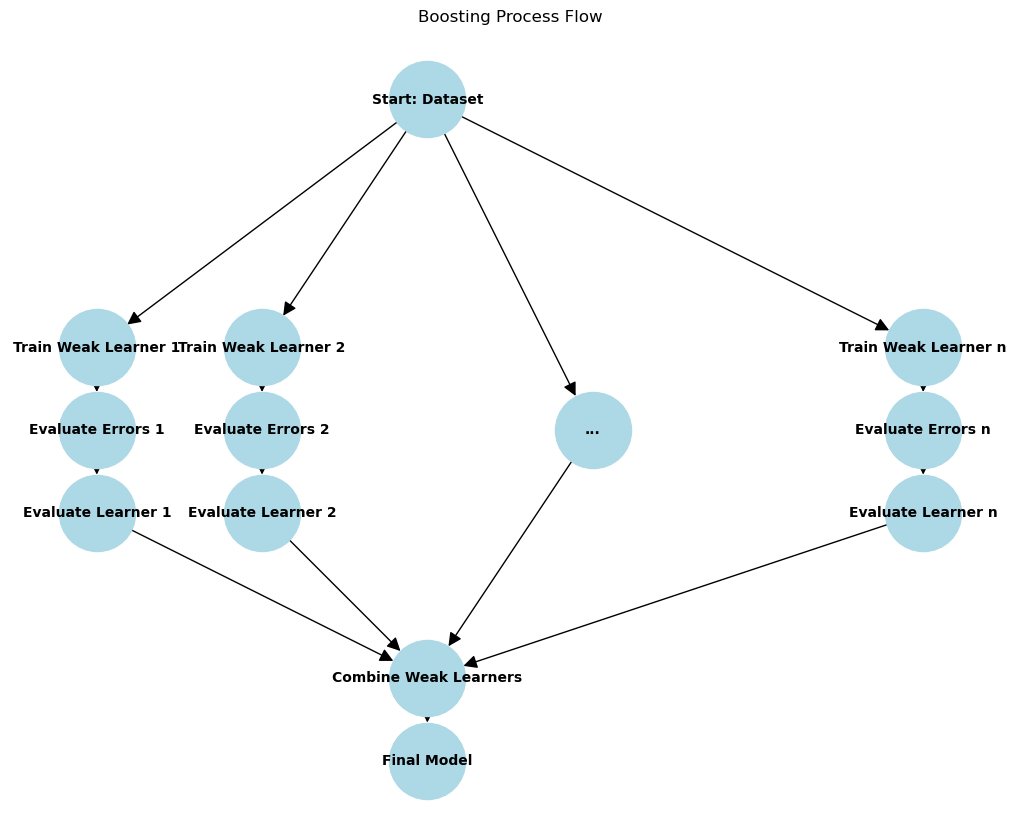

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

G.add_node("Start: Dataset", pos=(-1, 6))

G.add_node("Train Weak Learner 1", pos=(-3, 3))
G.add_node("Evaluate Errors 1", pos=(-3, 2))
G.add_node("Evaluate Learner 1", pos=(-3, 1))

G.add_node("Train Weak Learner 2", pos=(-2, 3))
G.add_node("Evaluate Errors 2", pos=(-2, 2))
G.add_node("Evaluate Learner 2", pos=(-2, 1))

G.add_node("Train Weak Learner n", pos=(2, 3))
G.add_node("Evaluate Errors n", pos=(2, 2))
G.add_node("Evaluate Learner n", pos=(2, 1))

G.add_node("...", pos=(0, 2))

G.add_node("Combine Weak Learners", pos=(-1, -1))
G.add_node("Final Model", pos=(-1, -2))


G.add_edges_from([
    ("Start: Dataset", "Train Weak Learner 1"),
    ("Start: Dataset", "Train Weak Learner 2"),
    ("Start: Dataset", "Train Weak Learner n"),
    ("Start: Dataset", "..."),

    ("Train Weak Learner 1", "Evaluate Errors 1"),
    ("Evaluate Errors 1", "Evaluate Learner 1"),
    ("Evaluate Learner 1", "Combine Weak Learners"),

    ("Train Weak Learner 2", "Evaluate Errors 2"),
    ("Evaluate Errors 2", "Evaluate Learner 2"),
    ("Evaluate Learner 2", "Combine Weak Learners"),

    ("Train Weak Learner n", "Evaluate Errors n"),
    ("Evaluate Errors n", "Evaluate Learner n"),
    ("Evaluate Learner n", "Combine Weak Learners"),

    ("...", "Combine Weak Learners"),

    ("Combine Weak Learners", "Final Model")
])

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title("Boosting Process Flow")
plt.show()

## XGBOOST

XGBoost, “Extreme Gradient Boost” specifically uses decision trees as weak learners as these are particularly well suited to gradient boosting.
With this technique trees can be built incrementally, once a subsequent tree is created it is defined to reduce the residual errors of the previous one, the direction in which to change the parameters is decided through gradient boosting. Notably, XG Boost does not use a weight for misinterpreted samples but uses the residual error to construct the next decision tree, which will aim to counterbalance the error of the previous one (also taking into account the learning rate).



ypred^(t+1)(x) = ypred^(t)(x)+ eta * f^(t)(x)

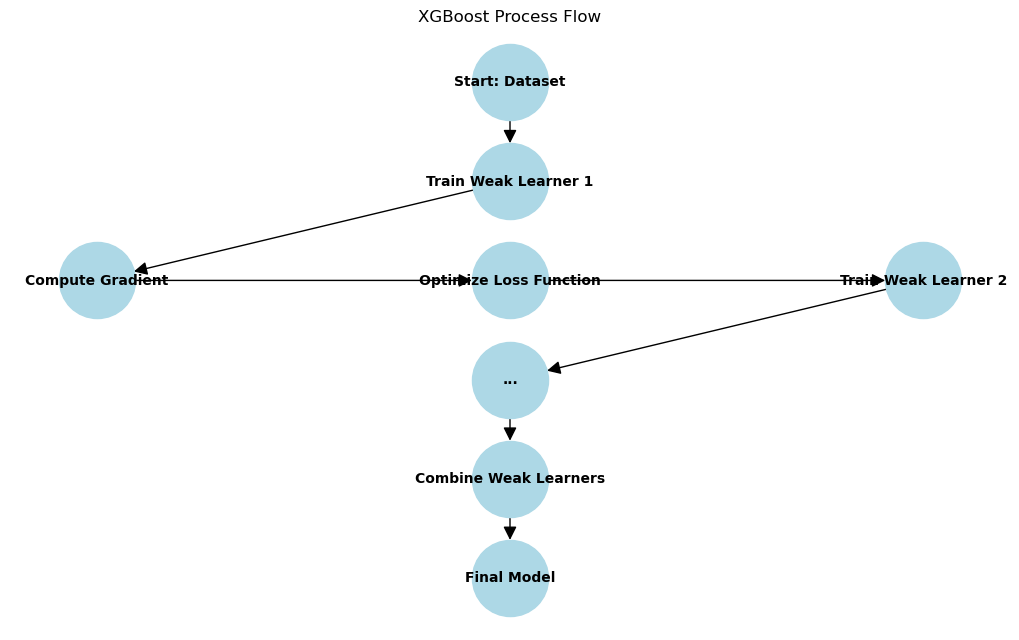

In [5]:
G = nx.DiGraph()

G.add_node("Start: Dataset", pos=(0, 4))
G.add_node("Train Weak Learner 1", pos=(0, 3))
G.add_node("Compute Gradient", pos=(-1, 2))
G.add_node("Optimize Loss Function", pos=(0, 2))
G.add_node("Train Weak Learner 2", pos=(1, 2))
G.add_node("...", pos=(0, 1))
G.add_node("Combine Weak Learners", pos=(0, 0))
G.add_node("Final Model", pos=(0, -1))

G.add_edges_from([
    ("Start: Dataset", "Train Weak Learner 1"),
    ("Train Weak Learner 1", "Compute Gradient"),
    ("Compute Gradient", "Optimize Loss Function"),
    ("Optimize Loss Function", "Train Weak Learner 2"),
    ("Train Weak Learner 2", "..."),
    ("...", "Combine Weak Learners"),
    ("Combine Weak Learners", "Final Model")
])

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title("XGBoost Process Flow")
plt.show()

- Hyperparameters for choice of approach, (type of learner, how error is evaluated, optimization function), here we leave the basic ones as the library already provides the best ones.

- Hyperparameters for the decision tree (basic model)

		max_depth:
	        Maximum depth of trees. Deeper trees can capture more complexity, but increase the risk of overfitting.


		min_child_weight:
		    Minimum weight per leaf node. A higher value reduces the probability of splitting and overfitting.


		subsample: (Checked when preparing the dataset).
		    Percentage of the data to be used to train each tree. A lower value may improve generalization, but risks reducing learning effectiveness.


		range:
            Higher value of gamma means that more significant gains are needed to perform a division at a node.


		lambda (L2 regularization):
	        Terminates L2 regularization to prevent overfitting.

		alpha (L1 regularization): (Not used).
        	Terminate of L1 regularization to prevent overfitting.

		colsample_bytree: (Not used).
	        Percentage of features (columns) to be used for each tree.

		colsample_bylevel: (Not used)
	        Percentage of features to be used for each level of the tree (finer than colsample_bytree).

		colsample_bynode: (Not used).
	        Percentage of features to be used for each node in the tree.


-Boosting and learning hyperparameters.

		learning_rate (eta):
	        Makes each update smaller and helps improve generalization. Smaller values require more trees.


		n_estimators:
	        Number of trees to build.


		scale_pos_weight: (If needed).
	        It is used in the case of unbalanced classes. Controls the weighting for the positive class.


		early_stopping_rounds: (If needed).
            If the score does not improve for a specified number of iterations, training is stopped.

In [3]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [19]:
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold , GridSearchCV, train_test_split,ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

RANDOM_SEED=42
NUM_FOLDS=5

X_train_set, X_val_set, Y_train_set, Y_val_set = train_test_split(
    X_train,y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=RANDOM_SEED,
    shuffle=True
)


num_negatives = (y_train == 0).sum()
num_positives = (y_train == 1).sum()
scale_pos_weight = num_negatives / num_positives
print(f"Unbalance report (scale_pos_weight): {scale_pos_weight}")

if scale_pos_weight>3:
    weights=[1, 3, 5, 10]
else:
    weights=[1]    

hyperparameters = {
    "max_depth": [2, 3], # Maximum depth of the tree
    "min_child_weight": [1, 2, 3], # Minimum sum of instance weight needed in a child
    "gamma": [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition
    "lambda": [0, 1, 2], # L2 regularization term on weights

    "learning_rate": [1, 0.1, 0.001, 0.0001], #eta, step size shrinkage
    "n_estimators": [25, 100, 250], # Number of trees
    "scale_pos_weight": weights, # Control the balance of positive and negative weights
}

grid_params=ParameterGrid(hyperparameters)



print(Y_train_set.value_counts())
print(Y_val_set.value_counts())

params_tested=list()

for comb in grid_params:

    rfc=XGBClassifier(**comb)
    rfc=rfc.fit(X_train_set,Y_train_set)
    
    Y_pred_train_set=rfc.predict(X_train_set)
    Y_pred_val_set=rfc.predict(X_val_set)
    
    train_f_score=f1_score(Y_train_set,Y_pred_train_set,average='weighted',zero_division=1)
    val_f_score=f1_score(Y_val_set,Y_pred_val_set,average='weighted',zero_division=1)
    test_f_score=f1_score(y_test,rfc.predict(X_test),average='weighted',zero_division=1)

    new_comb=comb

    new_comb|={
        'train_f1_score':train_f_score,
        'val_f1_score':val_f_score,
        'test_f1_score':test_f_score,
        'val_positives_f1_score':f1_score(Y_val_set,Y_pred_val_set,average='binary',pos_label=1,zero_division=1),
        'val_negatives_f1_score':f1_score(Y_val_set,Y_pred_val_set,average='binary',pos_label=0,zero_division=1),
    }

    print(comb)
    report_scores(Y_val_set,Y_pred_val_set)
    params_tested.append(new_comb)

params_df=pd.DataFrame(params_tested)
params_df.to_csv('xgboostresult.csv',index=False)




Unbalance report (scale_pos_weight): 1.0
label
0    368515
1    368515
Name: count, dtype: int64
label
0    92129
1    92129
Name: count, dtype: int64
{'gamma': 0, 'lambda': 0, 'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 25, 'scale_pos_weight': 1, 'train_f1_score': np.float64(0.689427173273395), 'val_f1_score': np.float64(0.6887714123921924), 'test_f1_score': np.float64(0.7807502769968666), 'val_positives_f1_score': np.float64(0.6798276738767232), 'val_negatives_f1_score': np.float64(0.6977151509076617)}
              precision    recall  f1-score   support

           0       0.68      0.72      0.70     92129
           1       0.70      0.66      0.68     92129

    accuracy                           0.69    184258
   macro avg       0.69      0.69      0.69    184258
weighted avg       0.69      0.69      0.69    184258

{'gamma': 0, 'lambda': 0, 'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1, 'tr

In [20]:
orderedpos=pd.read_csv('xgboostresult.csv')
best10=orderedpos.sort_values(by='val_f1_score',ascending=False).head(10)
best10

,gamma,lambda,learning_rate,max_depth,min_child_weight,n_estimators,scale_pos_weight,train_f1_score,val_f1_score,test_f1_score,val_positives_f1_score,val_negatives_f1_score
377,0.1,2,1.0,3,3,250,1,0.724716,0.719851,0.774840,0.713978,0.725724
593,0.2,2,1.0,3,3,250,1,0.724716,0.719851,0.774840,0.713978,0.725724
161,0.0,2,1.0,3,3,250,1,0.724716,0.719851,0.774840,0.713978,0.725724
443,0.2,0,1.0,3,1,250,1,0.724164,0.719365,0.780020,0.713542,0.725188
227,0.1,0,1.0,3,1,250,1,0.724164,0.719365,0.780020,0.713542,0.725188
11,0.0,0,1.0,3,1,250,1,0.724164,0.719365,0.780020,0.713542,0.725188
86,0.0,1,1.0,3,2,250,1,0.724324,0.718828,0.771087,0.713002,0.724654
302,0.1,1,1.0,3,2,250,1,0.724324,0.718828,0.771087,0.713002,0.724654
587,0.2,2,1.0,3,1,250,1,0.725199,0.718815,0.775443,0.712933,0.724696
371,0.1,2,1.0,3,1,250,1,0.725199,0.718815,0.775443,0.712933,0.724696


In [21]:
ordered=pd.read_csv('xgboostresult.csv')
best10=ordered.sort_values(by='val_f1_score',ascending=False).head(10)
best10

,gamma,lambda,learning_rate,max_depth,min_child_weight,n_estimators,scale_pos_weight,train_f1_score,val_f1_score,test_f1_score,val_positives_f1_score,val_negatives_f1_score
377,0.1,2,1.0,3,3,250,1,0.724716,0.719851,0.774840,0.713978,0.725724
593,0.2,2,1.0,3,3,250,1,0.724716,0.719851,0.774840,0.713978,0.725724
161,0.0,2,1.0,3,3,250,1,0.724716,0.719851,0.774840,0.713978,0.725724
443,0.2,0,1.0,3,1,250,1,0.724164,0.719365,0.780020,0.713542,0.725188
227,0.1,0,1.0,3,1,250,1,0.724164,0.719365,0.780020,0.713542,0.725188
11,0.0,0,1.0,3,1,250,1,0.724164,0.719365,0.780020,0.713542,0.725188
86,0.0,1,1.0,3,2,250,1,0.724324,0.718828,0.771087,0.713002,0.724654
302,0.1,1,1.0,3,2,250,1,0.724324,0.718828,0.771087,0.713002,0.724654
587,0.2,2,1.0,3,1,250,1,0.725199,0.718815,0.775443,0.712933,0.724696
371,0.1,2,1.0,3,1,250,1,0.725199,0.718815,0.775443,0.712933,0.724696


## ADABOOST
In contrast, the AdaBoost, which stands for “Adaptive boosting,” uses a different approach. If the XGboost used an incremental approach based on correcting the prediction of the previous tree the Adaboost uses a more typical approach i.e. weighting the models explicitly. The special feature of Adaboost compared to classical boosting models is that errors in the previous iteration become a weight in the samples involved, which the next learner will focus on. This addition again allows for an incremental approach that improves the performance of the overall model by focusing on the most comeplex samples to be predicted (at each iteration the vector of weights is normalized so as not to unbalance an iteration).



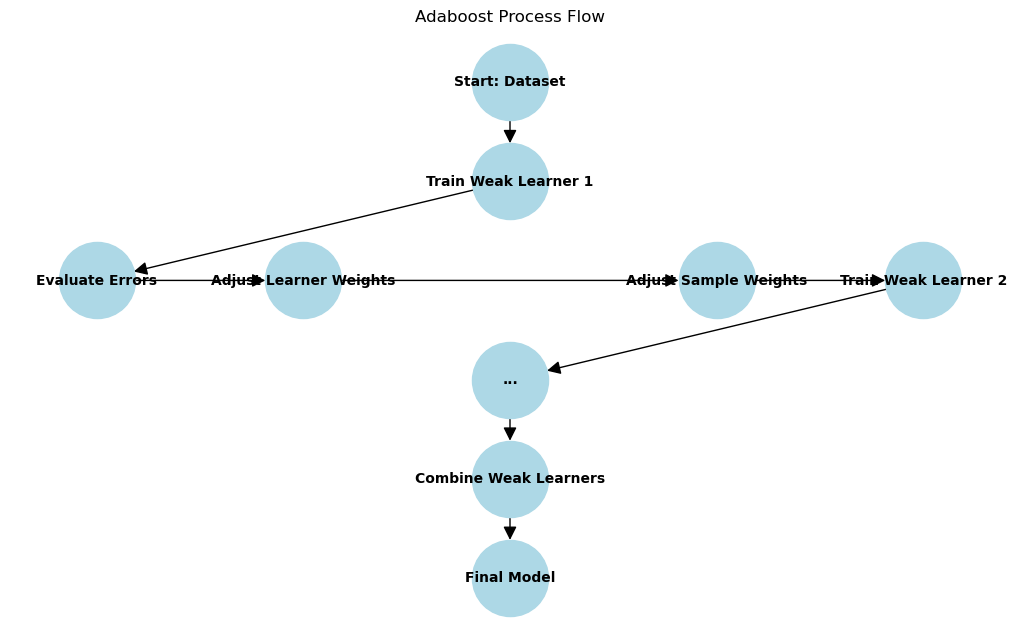

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Start: Dataset", pos=(0, 4))
G.add_node("Train Weak Learner 1", pos=(0, 3))
G.add_node("Evaluate Errors", pos=(-2, 2))
G.add_node("Adjust Learner Weights", pos=(-1, 2))
G.add_node("Adjust Sample Weights", pos=(1, 2))
G.add_node("Train Weak Learner 2", pos=(2, 2))
G.add_node("...", pos=(0, 1))
G.add_node("Combine Weak Learners", pos=(0, 0))
G.add_node("Final Model", pos=(0, -1))

# Add edges
G.add_edges_from([
    ("Start: Dataset", "Train Weak Learner 1"),
    ("Train Weak Learner 1", "Evaluate Errors"),
    ("Evaluate Errors", "Adjust Learner Weights"),
    ("Adjust Learner Weights", "Adjust Sample Weights"),
    ("Adjust Sample Weights", "Train Weak Learner 2"),
    ("Train Weak Learner 2", "..."),
    ("...", "Combine Weak Learners"),
    ("Combine Weak Learners", "Final Model")
])

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title("Adaboost Process Flow")
plt.show()

Unlike XGBoost, which was created specifically for decision trees, for the weak learners in AdaBoost I can use Logistic Regression (with threshold), KNN, and decision trees here as well. More complex models such as SVMs could be used if desired, but as not very “weak” the whole training process would become too cumbersome.

The hyperparameters used are:


1. Hyperparameters for creating the base model. 

	-base_estimator:
		Base model to be used. It can be any model, but generally weak decision trees are used, such as DecisionTreeClassifier(max_depth=1).


	-n_estimators:
		Number of weak models (trees) to train. More trees can improve performance, but increase the risk of overfitting.


2. Weighing control hyperparameters.

	-Learning_rate:
		Controls the impact of each weak classifier on the final output. A lower value reduces the impact of each tree.


3. Adjustment and optimization hyperparameters.

	-algorithm:
	    Tree combination method: 'SAMME' (Classic boosting method).

4. Stopping hyperparameters (early termination).

	-Random_state:
		Seed for generating random numbers. Useful for reproducibility of results.


In [11]:

hyperparameters = {
    "n_estimators": [25, 50, 100], # Number of weak learners
    "learning_rate": [1, 0.1, 0.01], # Weight of the weak learners
    "algorithm": ['SAMME', 'SAMME.R'], # Algorithm to use
    "random_state": [42] # Random seed
}


In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold , GridSearchCV, train_test_split,ParameterGrid
from sklearn.ensemble import RandomForestClassifier

RANDOM_SEED=42
NUM_FOLDS=5

hyperparameters = {
    "n_estimators":  [50, 100, 200], # Number of weak learners
    "learning_rate": [0.5, 0.1, 0.01, 0.001], # Weight of the weak learners
    "algorithm": ['SAMME.R'], # Algorithm to use

    "criterion": ['gini', 'entropy'], # Splitting criterion
    "max_depth": [2, 3, 4], # Maximum depth of the tree
    "max_leaf_nodes": [None, 5, 10], # Maximum number of leaf nodes


}

grid_params=ParameterGrid(hyperparameters)

X_train_set, X_val_set, Y_train_set, Y_val_set = train_test_split(
    X_train,y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=RANDOM_SEED,
    shuffle=True
)

params_tested=list()

for comb in grid_params:
    tree_base = tree.DecisionTreeClassifier(max_depth=comb["max_depth"],criterion=comb["criterion"],max_leaf_nodes=comb["max_leaf_nodes"]) # Decision tree as weak learner using the baset parametrers fuoudn in the previous step
    rfc = AdaBoostClassifier(estimator=tree_base, n_estimators=comb["n_estimators"], learning_rate=comb["learning_rate"], algorithm=comb["algorithm"], random_state=RANDOM_SEED)
    rfc=rfc.fit(X_train_set,Y_train_set)

    Y_pred_train_set=rfc.predict(X_train_set)

    Y_pred_val_set=rfc.predict(X_val_set)

    train_f_score=f1_score(Y_train_set,Y_pred_train_set,average='weighted', zero_division=1)
    val_f_score=f1_score(Y_val_set,Y_pred_val_set,average='weighted', zero_division=1)
    new_comb=comb
    
    new_comb|={
        'train_f1_score':train_f_score,
        'val_f1_score':val_f_score,
    }
    print(comb)
    report_scores(Y_val_set,Y_pred_val_set)
    params_tested.append(new_comb)

params_df=pd.DataFrame(params_tested)
ordered=params_df.sort_values(by='val_f1_score')
ordered.to_csv('adaboosttree.csv',index=False)

/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.8026805021018468, 'val_f1_score': 0.8005909168791544}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.67      0.15      0.25     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.57      0.58    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.8105886772876033, 'val_f1_score': 0.8083228471295151}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     92129
           1       0.67      0.18      0.29     18763

    accuracy                           0.85    110892
   macro avg       0.76      0.58      0.60    110892
weighted avg       0.82      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.8142372822001877, 'val_f1_score': 0.8119853043118119}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.69      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.8026805021018468, 'val_f1_score': 0.8005909168791544}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.67      0.15      0.25     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.57      0.58    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.8105886772876033, 'val_f1_score': 0.8083228471295151}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     92129
           1       0.67      0.18      0.29     18763

    accuracy                           0.85    110892
   macro avg       0.76      0.58      0.60    110892
weighted avg       0.82      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.8142372822001877, 'val_f1_score': 0.8119853043118119}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.69      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.8026805021018468, 'val_f1_score': 0.8005909168791544}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.67      0.15      0.25     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.57      0.58    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.8105886772876033, 'val_f1_score': 0.8083228471295151}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     92129
           1       0.67      0.18      0.29     18763

    accuracy                           0.85    110892
   macro avg       0.76      0.58      0.60    110892
weighted avg       0.82      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.8142372822001877, 'val_f1_score': 0.8119853043118119}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.69      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.8123160947486423, 'val_f1_score': 0.810366419580823}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     92129
           1       0.68      0.19      0.30     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.8189817076362318, 'val_f1_score': 0.8163871562512636}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.21      0.32     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.60      0.62    110892
weighted avg       0.83      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.8238582436242272, 'val_f1_score': 0.820362474679932}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.23      0.34     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.60      0.63    110892
weighted avg       0.84      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.8068166329521395, 'val_f1_score': 0.8050717067304017}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.68      0.17      0.27     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.58      0.59    110892
weighted avg       0.82      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.8131394435992312, 'val_f1_score': 0.810828800487001}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     92129
           1       0.67      0.19      0.30     18763

    accuracy                           0.85    110892
   macro avg       0.76      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.8190489200119713, 'val_f1_score': 0.8159659718806517}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.70      0.21      0.32     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.60      0.62    110892
weighted avg       0.83      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.8123160947486423, 'val_f1_score': 0.810366419580823}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     92129
           1       0.68      0.19      0.30     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.8189817076362318, 'val_f1_score': 0.8163871562512636}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.21      0.32     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.60      0.62    110892
weighted avg       0.83      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.8238582436242272, 'val_f1_score': 0.820362474679932}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.23      0.34     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.60      0.63    110892
weighted avg       0.84      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.8177833766156821, 'val_f1_score': 0.8142134875601141}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.69      0.21      0.32     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.62    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.8245539493980734, 'val_f1_score': 0.8204213565493781}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.23      0.34     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.60      0.63    110892
weighted avg       0.84      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.8300817412889996, 'val_f1_score': 0.8238016067111955}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.72      0.24      0.36     18763

    accuracy                           0.86    110892
   macro avg       0.79      0.61      0.64    110892
weighted avg       0.84      0.86      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.8100418216193874, 'val_f1_score': 0.8081124416569551}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.68      0.18      0.29     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.58      0.60    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.8146986325199316, 'val_f1_score': 0.8124644423688018}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.69      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.8209093838759025, 'val_f1_score': 0.8183175929164256}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.22      0.33     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.60      0.62    110892
weighted avg       0.84      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.8132851539747431, 'val_f1_score': 0.8109375048108083}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     92129
           1       0.68      0.19      0.30     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.8191879064733355, 'val_f1_score': 0.8161183040288742}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.69      0.21      0.33     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.60      0.62    110892
weighted avg       0.83      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.8265210904741264, 'val_f1_score': 0.8223377059826361}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.23      0.35     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.61      0.64    110892
weighted avg       0.84      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7842966020455986, 'val_f1_score': 0.7829013790306558}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.09      0.16     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7920396942631213, 'val_f1_score': 0.7914570836055781}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.56    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7994697212188874, 'val_f1_score': 0.7978159591666016}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.14      0.23     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7842966020455986, 'val_f1_score': 0.7829013790306558}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.09      0.16     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7920396942631213, 'val_f1_score': 0.7914570836055781}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.56    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7994697212188874, 'val_f1_score': 0.7978159591666016}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.14      0.23     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7842966020455986, 'val_f1_score': 0.7829013790306558}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.09      0.16     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7920396942631213, 'val_f1_score': 0.7914570836055781}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.56    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7994697212188874, 'val_f1_score': 0.7978159591666016}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.14      0.23     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7921660683024536, 'val_f1_score': 0.7908390171127677}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.55    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.8006579896162337, 'val_f1_score': 0.7992155373130096}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.15      0.24     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.57      0.58    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.8077944406034381, 'val_f1_score': 0.8061115469301174}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.70      0.17      0.27     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.58      0.59    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.790113990213523, 'val_f1_score': 0.7891224666262848}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.65      0.11      0.19     18763

    accuracy                           0.84    110892
   macro avg       0.75      0.55      0.55    110892
weighted avg       0.81      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7977461768023826, 'val_f1_score': 0.7964323235692784}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.67      0.14      0.23     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.8046913755372282, 'val_f1_score': 0.8027381260523033}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.69      0.16      0.26     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.57      0.59    110892
weighted avg       0.82      0.85      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7921660683024536, 'val_f1_score': 0.7908390171127677}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.55    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.8006579896162337, 'val_f1_score': 0.7992155373130096}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.15      0.24     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.57      0.58    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.8077944406034381, 'val_f1_score': 0.8061115469301174}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.70      0.17      0.27     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.58      0.59    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.8015513584790898, 'val_f1_score': 0.800110414932032}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.70      0.15      0.24     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.57      0.58    110892
weighted avg       0.83      0.85      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.8100470811378342, 'val_f1_score': 0.8082671407922242}
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     92129
           1       0.71      0.18      0.28     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.58      0.60    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.8166744597274508, 'val_f1_score': 0.8129960475959291}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.72      0.19      0.30     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7906079360723405, 'val_f1_score': 0.7898655483779312}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.66      0.11      0.19     18763

    accuracy                           0.84    110892
   macro avg       0.75      0.55      0.55    110892
weighted avg       0.81      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.8008510076763801, 'val_f1_score': 0.7994621857606687}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.15      0.24     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.57      0.58    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.8064642610055601, 'val_f1_score': 0.804716027164632}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.70      0.16      0.27     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.57      0.59    110892
weighted avg       0.83      0.85      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7997050094945632, 'val_f1_score': 0.7982023524544325}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.69      0.14      0.23     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.8079090121149782, 'val_f1_score': 0.8057494093880093}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.70      0.17      0.27     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.58      0.59    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.813631227962523, 'val_f1_score': 0.8115583117752356}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.72      0.19      0.30     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7671318238021576, 'val_f1_score': 0.7670967826234647}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     92129
           1       0.72      0.04      0.07     18763

    accuracy                           0.83    110892
   macro avg       0.78      0.52      0.49    110892
weighted avg       0.82      0.83      0.77    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7671318238021576, 'val_f1_score': 0.7670967826234647}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     92129
           1       0.72      0.04      0.07     18763

    accuracy                           0.83    110892
   macro avg       0.78      0.52      0.49    110892
weighted avg       0.82      0.83      0.77    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7671318238021576, 'val_f1_score': 0.7670967826234647}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     92129
           1       0.72      0.04      0.07     18763

    accuracy                           0.83    110892
   macro avg       0.78      0.52      0.49    110892
weighted avg       0.82      0.83      0.77    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7758073998864141, 'val_f1_score': 0.7753020623665161}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.06      0.11     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7745468925691145, 'val_f1_score': 0.7739590785134566}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     92129
           1       0.71      0.06      0.11     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.82      0.84      0.77    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7796035641923076, 'val_f1_score': 0.7789053821214305}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7777221091712424, 'val_f1_score': 0.7770777018533352}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.07      0.12     18763

    accuracy                           0.84    110892
   macro avg       0.75      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7789431844159339, 'val_f1_score': 0.7785221157811967}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.65      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.75      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7784285632060386, 'val_f1_score': 0.7778616159090653}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7758073998864141, 'val_f1_score': 0.7753020623665161}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.06      0.11     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7745468925691145, 'val_f1_score': 0.7739590785134566}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     92129
           1       0.71      0.06      0.11     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.82      0.84      0.77    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7796035641923076, 'val_f1_score': 0.7789053821214305}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7857614260473489, 'val_f1_score': 0.7848227052955766}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.62      0.10      0.17     18763

    accuracy                           0.84    110892
   macro avg       0.73      0.54      0.54    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7818055456077607, 'val_f1_score': 0.7811787856232679}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.68      0.08      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7903605344895986, 'val_f1_score': 0.7888992134299725}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.11      0.19     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.55      0.55    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.780126241940668, 'val_f1_score': 0.7796626996436017}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.65      0.08      0.14     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.53      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7755455761165151, 'val_f1_score': 0.7751609892989163}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.06      0.11     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7785387674865406, 'val_f1_score': 0.777669392485911}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7808559976150791, 'val_f1_score': 0.7804565856164778}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.66      0.08      0.14     18763

    accuracy                           0.84    110892
   macro avg       0.75      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7792899858528504, 'val_f1_score': 0.7788442732432543}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7849696065649364, 'val_f1_score': 0.7839348094708566}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.68      0.09      0.16     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.54      0.54    110892
weighted avg       0.82      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7873622767207618, 'val_f1_score': 0.7865093564243048}
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     92129
           1       0.59      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7869190880060215, 'val_f1_score': 0.7862231636359117}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.60      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7785404320120156, 'val_f1_score': 0.7779473548722583}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.65      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.75      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7873622767207618, 'val_f1_score': 0.7865093564243048}
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     92129
           1       0.59      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7869190880060215, 'val_f1_score': 0.7862231636359117}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.60      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7869190880060215, 'val_f1_score': 0.7862231636359117}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.60      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7873622767207618, 'val_f1_score': 0.7865093564243048}
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     92129
           1       0.59      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7869190880060215, 'val_f1_score': 0.7862231636359117}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.60      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7785404320120156, 'val_f1_score': 0.7779473548722583}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.65      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.75      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7873622767207618, 'val_f1_score': 0.7865093564243048}
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     92129
           1       0.59      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7873492555639662, 'val_f1_score': 0.7864917332750225}
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     92129
           1       0.59      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.787327191054885, 'val_f1_score': 0.786386680696213}
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     92129
           1       0.59      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7873622767207618, 'val_f1_score': 0.7865093564243048}
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     92129
           1       0.59      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7869190880060215, 'val_f1_score': 0.7862231636359117}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.60      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7869190880060215, 'val_f1_score': 0.7862231636359117}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.60      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7873622767207618, 'val_f1_score': 0.7865093564243048}
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     92129
           1       0.59      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7876194568030985, 'val_f1_score': 0.7866207912282309}
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     92129
           1       0.59      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'gini', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7873230434793522, 'val_f1_score': 0.786391907927864}
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     92129
           1       0.59      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.8035467825946548, 'val_f1_score': 0.8025739630894165}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.67      0.16      0.26     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.57      0.59    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.8096874201422736, 'val_f1_score': 0.8079015588978982}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     92129
           1       0.67      0.18      0.29     18763

    accuracy                           0.85    110892
   macro avg       0.76      0.58      0.60    110892
weighted avg       0.82      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.8142554312445176, 'val_f1_score': 0.8124443341231606}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.68      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.8035467825946548, 'val_f1_score': 0.8025739630894165}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.67      0.16      0.26     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.57      0.59    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.8096874201422736, 'val_f1_score': 0.8079015588978982}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     92129
           1       0.67      0.18      0.29     18763

    accuracy                           0.85    110892
   macro avg       0.76      0.58      0.60    110892
weighted avg       0.82      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.8142554312445176, 'val_f1_score': 0.8124443341231606}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.68      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.8035467825946548, 'val_f1_score': 0.8025739630894165}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.67      0.16      0.26     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.57      0.59    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.8096874201422736, 'val_f1_score': 0.8079015588978982}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     92129
           1       0.67      0.18      0.29     18763

    accuracy                           0.85    110892
   macro avg       0.76      0.58      0.60    110892
weighted avg       0.82      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.8142554312445176, 'val_f1_score': 0.8124443341231606}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.68      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.8092297539611774, 'val_f1_score': 0.8079775698528279}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.68      0.18      0.29     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.58      0.60    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.8155909105007635, 'val_f1_score': 0.8135987160311626}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.70      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.8215664519734911, 'val_f1_score': 0.8181872986448328}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.22      0.33     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.60      0.62    110892
weighted avg       0.83      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.8084068141996815, 'val_f1_score': 0.8068792602372139}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.68      0.18      0.28     18763

    accuracy                           0.85    110892
   macro avg       0.76      0.58      0.60    110892
weighted avg       0.82      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.8138364750116291, 'val_f1_score': 0.8115205046357883}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.70      0.19      0.30     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.8190643371954629, 'val_f1_score': 0.816417454783273}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.21      0.32     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.60      0.62    110892
weighted avg       0.83      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.8092297539611774, 'val_f1_score': 0.8079775698528279}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.68      0.18      0.29     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.58      0.60    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.8155909105007635, 'val_f1_score': 0.8135987160311626}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.70      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.8215664519734911, 'val_f1_score': 0.8181872986448328}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.22      0.33     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.60      0.62    110892
weighted avg       0.83      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.81954207428217, 'val_f1_score': 0.8170223386379264}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.70      0.21      0.33     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.60      0.62    110892
weighted avg       0.83      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.8255670327962751, 'val_f1_score': 0.8213701531193196}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.23      0.35     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.61      0.63    110892
weighted avg       0.84      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.8299253342324018, 'val_f1_score': 0.8242533116039962}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.72      0.24      0.36     18763

    accuracy                           0.86    110892
   macro avg       0.79      0.61      0.64    110892
weighted avg       0.84      0.86      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.8080598724646407, 'val_f1_score': 0.8057513558116259}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.67      0.17      0.28     18763

    accuracy                           0.85    110892
   macro avg       0.76      0.58      0.59    110892
weighted avg       0.82      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.8150062719147513, 'val_f1_score': 0.8129027052843028}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.70      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.8201428549318861, 'val_f1_score': 0.8170759626517146}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.72      0.21      0.33     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.60      0.62    110892
weighted avg       0.84      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.8152368973867066, 'val_f1_score': 0.8125763239797149}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.68      0.20      0.31     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.821718832076532, 'val_f1_score': 0.8186423761823854}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.71      0.22      0.33     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.60      0.63    110892
weighted avg       0.84      0.85      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.5, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.8270382980626808, 'val_f1_score': 0.8227522518491287}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.73      0.23      0.35     18763

    accuracy                           0.86    110892
   macro avg       0.79      0.61      0.64    110892
weighted avg       0.84      0.86      0.82    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7848374360247663, 'val_f1_score': 0.7832225559222383}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.09      0.16     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7926422053238001, 'val_f1_score': 0.7917348385465546}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.67      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.56    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7996183287681079, 'val_f1_score': 0.798097399732019}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.67      0.14      0.24     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7848374360247663, 'val_f1_score': 0.7832225559222383}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.09      0.16     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7926422053238001, 'val_f1_score': 0.7917348385465546}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.67      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.56    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7996183287681079, 'val_f1_score': 0.798097399732019}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.67      0.14      0.24     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7848374360247663, 'val_f1_score': 0.7832225559222383}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.09      0.16     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7926422053238001, 'val_f1_score': 0.7917348385465546}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.67      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.56    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7996183287681079, 'val_f1_score': 0.798097399732019}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.67      0.14      0.24     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7929063145242994, 'val_f1_score': 0.7918937630894634}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.67      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.56    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.8006307232563, 'val_f1_score': 0.7988443333635494}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.15      0.24     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.57      0.58    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.808528832242003, 'val_f1_score': 0.806690002920278}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.70      0.17      0.28     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.58      0.60    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7888603672702451, 'val_f1_score': 0.787470156884015}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.10      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.55    110892
weighted avg       0.81      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7996384505948666, 'val_f1_score': 0.7980649276570587}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.14      0.23     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.8051841273146216, 'val_f1_score': 0.8033788323900997}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.69      0.16      0.26     18763

    accuracy                           0.85    110892
   macro avg       0.77      0.57      0.59    110892
weighted avg       0.82      0.85      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7929063145242994, 'val_f1_score': 0.7918937630894634}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.67      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.56    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.8006307232563, 'val_f1_score': 0.7988443333635494}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.68      0.15      0.24     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.57      0.58    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.808528832242003, 'val_f1_score': 0.806690002920278}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.70      0.17      0.28     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.58      0.60    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.8025865338021623, 'val_f1_score': 0.8008402278274015}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.70      0.15      0.25     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.57      0.58    110892
weighted avg       0.83      0.85      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.8096819953655494, 'val_f1_score': 0.8076922638165227}
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     92129
           1       0.71      0.17      0.28     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.58      0.60    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.8159787020685438, 'val_f1_score': 0.8124034924096761}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     92129
           1       0.72      0.19      0.30     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.59      0.61    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7900739105244727, 'val_f1_score': 0.7887673882285374}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.11      0.19     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.55      0.55    110892
weighted avg       0.81      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7988466015542401, 'val_f1_score': 0.7978166508243043}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.67      0.14      0.23     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.8058977906729923, 'val_f1_score': 0.8041376767303284}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.70      0.16      0.26     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.57      0.59    110892
weighted avg       0.83      0.85      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7987081815934708, 'val_f1_score': 0.7968850781494804}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.70      0.14      0.23     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.56      0.57    110892
weighted avg       0.82      0.84      0.80    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.8072348215940915, 'val_f1_score': 0.8050827935757299}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     92129
           1       0.70      0.17      0.27     18763

    accuracy                           0.85    110892
   macro avg       0.78      0.58      0.59    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.1, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.8129297732282452, 'val_f1_score': 0.8101406959555292}
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     92129
           1       0.72      0.18      0.29     18763

    accuracy                           0.85    110892
   macro avg       0.79      0.58      0.60    110892
weighted avg       0.83      0.85      0.81    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7648529799202253, 'val_f1_score': 0.7649258955145639}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.73      0.03      0.06     18763

    accuracy                           0.83    110892
   macro avg       0.78      0.51      0.48    110892
weighted avg       0.82      0.83      0.76    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7648529799202253, 'val_f1_score': 0.7649258955145639}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.73      0.03      0.06     18763

    accuracy                           0.83    110892
   macro avg       0.78      0.51      0.48    110892
weighted avg       0.82      0.83      0.76    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7648529799202253, 'val_f1_score': 0.7649258955145639}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.73      0.03      0.06     18763

    accuracy                           0.83    110892
   macro avg       0.78      0.51      0.48    110892
weighted avg       0.82      0.83      0.76    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7759727478678867, 'val_f1_score': 0.7754352111003582}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.06      0.11     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.774477252968601, 'val_f1_score': 0.7739468369652318}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     92129
           1       0.71      0.06      0.11     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.82      0.84      0.77    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7791801470627568, 'val_f1_score': 0.7784532489630124}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.70      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.52    110892
weighted avg       0.82      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.777652962748553, 'val_f1_score': 0.7768286639182733}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.66      0.07      0.12     18763

    accuracy                           0.84    110892
   macro avg       0.75      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7693235797499107, 'val_f1_score': 0.7688715351296577}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     92129
           1       0.69      0.04      0.08     18763

    accuracy                           0.83    110892
   macro avg       0.76      0.52      0.49    110892
weighted avg       0.81      0.83      0.77    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7766858299102432, 'val_f1_score': 0.775676303958346}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.06      0.12     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7759727478678867, 'val_f1_score': 0.7754352111003582}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.06      0.11     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.774477252968601, 'val_f1_score': 0.7739468369652318}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     92129
           1       0.71      0.06      0.11     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.82      0.84      0.77    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7791801470627568, 'val_f1_score': 0.7784532489630124}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.70      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.52    110892
weighted avg       0.82      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.785500126547992, 'val_f1_score': 0.7842573602278451}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.63      0.10      0.17     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.54    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7821323732022256, 'val_f1_score': 0.7816391425254088}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.68      0.08      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7902582290635116, 'val_f1_score': 0.7883232612382607}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.69      0.11      0.18     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.55      0.55    110892
weighted avg       0.82      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.777652962748553, 'val_f1_score': 0.7768286639182733}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.66      0.07      0.12     18763

    accuracy                           0.84    110892
   macro avg       0.75      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7694026198178298, 'val_f1_score': 0.7690623767932998}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     92129
           1       0.70      0.04      0.08     18763

    accuracy                           0.83    110892
   macro avg       0.77      0.52      0.49    110892
weighted avg       0.81      0.83      0.77    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7755761353197428, 'val_f1_score': 0.7749273669495028}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.71      0.06      0.11     18763

    accuracy                           0.84    110892
   macro avg       0.77      0.53      0.51    110892
weighted avg       0.82      0.84      0.77    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.780067687641389, 'val_f1_score': 0.7794738693592254}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.66      0.08      0.14     18763

    accuracy                           0.84    110892
   macro avg       0.75      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7790040540286609, 'val_f1_score': 0.7786705168016037}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.67      0.07      0.13     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.53      0.52    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.01, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7848896870257815, 'val_f1_score': 0.7837241767889996}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.68      0.09      0.16     18763

    accuracy                           0.84    110892
   macro avg       0.76      0.54      0.54    110892
weighted avg       0.82      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7540171481244617, 'val_f1_score': 0.7540176834235754}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7891430527586845, 'val_f1_score': 0.7884627930158854}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.58      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.71      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7891430527586845, 'val_f1_score': 0.7884627930158854}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.58      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.71      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.7812625808749832, 'val_f1_score': 0.780715286743754}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.64      0.08      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7813453650742764, 'val_f1_score': 0.7807468967043485}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.63      0.08      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7813453650742764, 'val_f1_score': 0.7807468967043485}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.63      0.08      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7813453650742764, 'val_f1_score': 0.7807468967043485}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.63      0.08      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7891430527586845, 'val_f1_score': 0.7884627930158854}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.58      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.71      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7891430527586845, 'val_f1_score': 0.7884627930158854}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.58      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.71      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.7812625808749832, 'val_f1_score': 0.780715286743754}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.64      0.08      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 50, 'train_f1_score': 0.7891430527586845, 'val_f1_score': 0.7884627930158854}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.58      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.71      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 100, 'train_f1_score': 0.7891430527586845, 'val_f1_score': 0.7884627930158854}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.58      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.71      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': None, 'n_estimators': 200, 'train_f1_score': 0.783194829942605, 'val_f1_score': 0.7825327141294607}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.63      0.09      0.16     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 50, 'train_f1_score': 0.7813453650742764, 'val_f1_score': 0.7807468967043485}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.63      0.08      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 100, 'train_f1_score': 0.7813453650742764, 'val_f1_score': 0.7807468967043485}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.63      0.08      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 200, 'train_f1_score': 0.7813453650742764, 'val_f1_score': 0.7807468967043485}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.63      0.08      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 50, 'train_f1_score': 0.7891430527586845, 'val_f1_score': 0.7884627930158854}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.58      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.71      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 100, 'train_f1_score': 0.7891430527586845, 'val_f1_score': 0.7884627930158854}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     92129
           1       0.58      0.12      0.20     18763

    accuracy                           0.84    110892
   macro avg       0.71      0.55      0.55    110892
weighted avg       0.80      0.84      0.79    110892



/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'criterion': 'entropy', 'learning_rate': 0.001, 'max_depth': 4, 'max_leaf_nodes': 10, 'n_estimators': 200, 'train_f1_score': 0.782127511063485, 'val_f1_score': 0.7814850343486469}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     92129
           1       0.63      0.09      0.15     18763

    accuracy                           0.84    110892
   macro avg       0.74      0.54      0.53    110892
weighted avg       0.81      0.84      0.78    110892



In [2]:
import pandas as pd
ordered=pd.read_csv('adaboosttreefinal.csv')
best10=ordered.sort_values(by='val_f1_score',ascending=False).head(10)
best10

,algorithm,criterion,learning_rate,max_depth,max_leaf_nodes,n_estimators,train_f1_score,val_f1_score
215,SAMME.R,entropy,0.5,4,NaN,200,0.829925,0.824253
214,SAMME.R,gini,0.5,4,NaN,200,0.830082,0.823802
213,SAMME.R,entropy,0.5,4,10.0,200,0.827038,0.822752
212,SAMME.R,gini,0.5,4,10.0,200,0.826521,0.822338
211,SAMME.R,entropy,0.5,4,NaN,100,0.825567,0.821370
210,SAMME.R,gini,0.5,4,NaN,100,0.824554,0.820421
209,SAMME.R,gini,0.5,3,10.0,200,0.823858,0.820362
208,SAMME.R,gini,0.5,3,NaN,200,0.823858,0.820362
207,SAMME.R,entropy,0.5,4,10.0,100,0.821719,0.818642
206,SAMME.R,gini,0.5,4,5.0,200,0.820909,0.818318
